In [1]:
import yaml
import mysql.connector
import os
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import squarify
import geopandas as gpd
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
import folium

import scipy.stats as stats
from scipy.stats import ks_2samp
from scipy.stats import kstest, norm
from scipy.stats import levene
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from scipy.stats import chi2_contingency

# Now you can use chi2_contingency function in your code


#from sklearn.preprocessing import LabelEncoder, StandardScaler
#from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings('ignore')
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

In [2]:
# Load the YAML file
with open("D:\Telangana_Growth_Analysis\db_config.yaml", 'r') as file:
    db_config = yaml.safe_load(file)

# Connect to the database
connection = mysql.connector.connect(**db_config)
cursor = connection.cursor()

In [4]:
# SQL query to join 'fact_stamps' and 'dim_districts' on 'dist_code'

query = """
    select * from investments
    inner join districts on investments.dist_code = districts.dist_code
    """
# Use pandas to run the query and store the result in a DataFrame
investments = pd.read_sql(query, connection)

# Sort the DataFrame by the 'id' column in ascending order
investments.sort_values(by='id', ascending=True, inplace=True)
investments.reset_index(drop=True, inplace=True)


# Load the 'dim_date' table into a DataFrame
dim_date = pd.read_sql("SELECT * FROM dim_date", connection)

# Merge the 'vehicles' DataFrame with the 'dim_date' DataFrame on the 'month' column
investments = pd.merge(investments, dim_date, on='month', how='inner')
# Display the first few rows of the merged DataFrame

# Set Pandas display options to show all columns
pd.set_option('display.max_columns', None)
investments.head()

,id,dist_code,month,sector,investment_in_cr,number_of_employees,dist_code,district,mmm,quarter,fiscal_year
0,1,14_1,2019-04-01,Engineering,2.32,15,14_1,Mahabubnagar\r,Apr,Q1,2019
1,2,19_1,2019-04-01,Engineering,0.63,13,19_1,Adilabad\r,Apr,Q1,2019
2,3,20_3,2019-04-01,Wood and Leather,0.20,8,20_3,Rajanna Sircilla\r,Apr,Q1,2019
3,4,20_3,2019-04-01,Textiles,0.27,27,20_3,Rajanna Sircilla\r,Apr,Q1,2019
4,5,21_5,2019-04-01,Electrical and Electronic Products,0.12,5,21_5,Mahabubabad\r,Apr,Q1,2019


In [5]:
#The \r is a carriage return character. 
# it can remove it from the district column using the str.replace method provided by pandas.

investments['district'] = investments['district'].str.replace('\r', '')

# drop dis_code
investments.drop(columns=['dist_code','dist_code'], inplace=True)

investments.head()

,id,month,sector,investment_in_cr,number_of_employees,district,mmm,quarter,fiscal_year
0,1,2019-04-01,Engineering,2.32,15,Mahabubnagar,Apr,Q1,2019
1,2,2019-04-01,Engineering,0.63,13,Adilabad,Apr,Q1,2019
2,3,2019-04-01,Wood and Leather,0.20,8,Rajanna Sircilla,Apr,Q1,2019
3,4,2019-04-01,Textiles,0.27,27,Rajanna Sircilla,Apr,Q1,2019
4,5,2019-04-01,Electrical and Electronic Products,0.12,5,Mahabubabad,Apr,Q1,2019


In [7]:
investments.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5753 entries, 0 to 5752
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   5753 non-null   int64  
 1   month                5753 non-null   object 
 2   sector               5753 non-null   object 
 3   investment_in_cr     5753 non-null   float64
 4   number_of_employees  5753 non-null   int64  
 5   district             5753 non-null   object 
 6   mmm                  5753 non-null   object 
 7   quarter              5753 non-null   object 
 8   fiscal_year          5753 non-null   int64  
dtypes: float64(1), int64(3), object(5)
memory usage: 449.5+ KB


In [8]:
# change date to datetime type

investments['month'] = pd.to_datetime(investments['month'])

In [9]:
investments.describe()

,id,investment_in_cr,number_of_employees,fiscal_year
count,5753.000000,5753.000000,5753.000000,5753.000000
mean,2877.000000,17.231975,117.344168,2020.519555
std,1660.892381,257.427150,1398.725287,1.109453
min,1.000000,0.000000,0.000000,2019.000000
25%,1439.000000,0.220000,7.000000,2020.000000
50%,2877.000000,0.740000,15.000000,2021.000000
75%,4315.000000,3.120000,40.000000,2021.000000
max,5753.000000,17793.350000,57000.000000,2022.000000


### Investment and Employee Analysis

#### Investment (in Cr):

- **Range:** The investments range from a minimum of 0 Cr to a substantial 17,793.35 Cr.
- **Central Tendency:** On average, entities have an investment of approximately 17.23 Cr.
- **Variability:** The standard deviation is 257.43, indicating a wide spread in the investment amounts across entities.
- **Distribution:** 
  - Half of the entities have investments less than or equal to 0.74 Cr.
  - 25% have investments of 0.22 Cr or less.
  - 75% have investments of 3.12 Cr or less.

#### Number of Employees:

- **Range:** Entities have employee counts ranging from 0 to a significant 57,000.
- **Central Tendency:** The average number of employees in these entities is around 117.34. However, this average is influenced by outliers, as the median (or the 50th percentile) is only 15.
- **Variability:** A high standard deviation of 1,398.73 suggests a significant variation in the number of employees across entities.
- **Distribution:**
  - 25% of entities have 7 employees or fewer.
  - 75% have 40 employees or fewer.
  
This suggests that a majority of entities in this dataset are relatively small in size.


In [10]:
# Load the GeoJSON data
map_file = (r"D:\Telangana_Growth_Analysis\Telangana_Shape_Files\telangana_district_map.json")
geo_data = gpd.read_file(map_file)

In [12]:
#%matplotlib inline
# Create the profile report
#profile = ProfileReport(investments, title="Profiling Report")

# Specify the path to save the report
#output_file_path = "D:\\Telangana_Growth_Analysis\\y_data\\profiling_report.html"

# Save the report to the specified path
#profile.to_file(output_file_path)

In [16]:
investments.columns

Index(['id', 'month', 'sector', 'investment_in_cr', 'number_of_employees',
       'district', 'mmm', 'quarter', 'fiscal_year'],
      dtype='object')

In [15]:
investments[investments['investment_in_cr'] == investments['investment_in_cr'].max()]

,id,month,sector,investment_in_cr,number_of_employees,district,mmm,quarter,fiscal_year
1177,1178,2020-02-01,"Real Estate,Industrial Parks and IT Buildings",17793.35,25419,Rangareddy,Feb,Q4,2019


In [17]:
investments[investments['number_of_employees'] == investments['number_of_employees'].max()]

,id,month,sector,investment_in_cr,number_of_employees,district,mmm,quarter,fiscal_year
1065,1066,2020-01-01,"Real Estate,Industrial Parks and IT Buildings",394.0,57000,Rangareddy,Jan,Q4,2019


In [18]:
investments.nlargest(5, 'investment_in_cr')

,id,month,sector,investment_in_cr,number_of_employees,district,mmm,quarter,fiscal_year
1177,1178,2020-02-01,"Real Estate,Industrial Parks and IT Buildings",17793.35,25419,Rangareddy,Feb,Q4,2019
939,940,2019-12-01,"Fertlizers Organic and Inorganic,Pesticides,In...",5254.28,450,Peddapalli,Dec,Q3,2019
4178,4179,2022-03-01,"Real Estate,Industrial Parks and IT Buildings",1862.73,144,Rangareddy,Mar,Q4,2021
5328,5329,2022-12-01,Plastic and Rubber,1556.07,307,Rangareddy,Dec,Q3,2022
5448,5449,2023-01-01,Plastic and Rubber,1553.00,1812,Sangareddy,Jan,Q4,2022


In [19]:
investments.nlargest(5, 'number_of_employees')

,id,month,sector,investment_in_cr,number_of_employees,district,mmm,quarter,fiscal_year
1065,1066,2020-01-01,"Real Estate,Industrial Parks and IT Buildings",394.00,57000,Rangareddy,Jan,Q4,2019
2628,2629,2021-02-01,"Real Estate,Industrial Parks and IT Buildings",0.00,40541,Rangareddy,Feb,Q4,2020
170,171,2019-05-01,"Real Estate,Industrial Parks and IT Buildings",847.82,40250,Rangareddy,May,Q1,2019
2697,2698,2021-03-01,"Real Estate,Industrial Parks and IT Buildings",0.00,31315,Rangareddy,Mar,Q4,2020
1681,1682,2020-07-01,"Real Estate,Industrial Parks and IT Buildings",149.00,27000,Rangareddy,Jul,Q2,2020


In [21]:
investments[(investments['investment_in_cr'] == 0) | (investments['number_of_employees'] == 0)]

,id,month,sector,investment_in_cr,number_of_employees,district,mmm,quarter,fiscal_year
8,9,2019-04-01,Engineering,0.03,0,Nirmal,Apr,Q1,2019
44,45,2019-04-01,Granite and Stone Crushing,0.00,5,Medchal_Malkajgiri,Apr,Q1,2019
45,46,2019-04-01,Pharmaceuticals and Chemicals,0.00,75,Yadadri Bhuvanagiri,Apr,Q1,2019
72,73,2019-04-01,Wood and Leather,0.00,12,Sangareddy,Apr,Q1,2019
74,75,2019-04-01,Plastic and Rubber,33.60,0,Sangareddy,Apr,Q1,2019
...,...,...,...,...,...,...,...,...,...
3974,3975,2022-01-01,Wood and Leather,0.00,8,Nirmal,Jan,Q4,2021
4017,4018,2022-01-01,"Cement, Cement & Concrete Products, Fly Ash Br...",0.00,0,Suryapet,Jan,Q4,2021
5004,5005,2022-09-01,Granite and Stone Crushing,0.00,104,Mahabubnagar,Sep,Q2,2022
5110,5111,2022-09-01,Paper and Printing,0.00,200,Sangareddy,Sep,Q2,2022


In [24]:
# Box plot
fig_box = go.Figure()

fig_box.add_trace(go.Box(y=investments['investment_in_cr'], name='Investment in Cr'))
fig_box.add_trace(go.Box(y=investments['number_of_employees'], name='Number of Employees'))
fig_box.update_layout(title_text="Box Plot of Investment and Number of Employees")

fig_box.show()

# Violin plot
fig_violin = go.Figure()

fig_violin.add_trace(go.Violin(y=investments['investment_in_cr'], box_visible=True, line_color='blue', name='Investment in Cr'))
fig_violin.add_trace(go.Violin(y=investments['number_of_employees'], box_visible=True, line_color='green', name='Number of Employees'))
fig_violin.update_layout(title_text="Violin Plot of Investment and Number of Employees")

fig_violin.show()

Assuming data is correct, there extreme outliers  

**Note on Outliers in the Data:**

The dataset contains some extreme outliers, particularly in the 'investment_in_cr' and 'number_of_employees' columns:

- The most extreme outlier in the 'investment_in_cr' column is a staggering 17,793.35 Cr.

- The next highest investment value is significantly lower, standing at 5,254 Cr.

- Interestingly, 75% of the data points have investments below the threshold of 3.15 Cr, highlighting the substantial variation in investment amounts.

- On the employee front, the dataset includes an entity with an extraordinarily high employee count of 57,000.

- While the average number of employees across entities is approximately 117.34, it's essential to note that this average is significantly influenced by these outliers. The median value, which provides a more robust representation, stands at just 15.

- The majority of entities, precisely 75%, have a workforce of 40 employees or fewer, underscoring the prevalence of relatively smaller-sized entities in the dataset.

In [26]:
investments['sector'].value_counts()

Food Processing                                                                1065
Engineering                                                                     692
Cement, Cement & Concrete Products, Fly Ash Bricks                              659
Agro based incl Cold Storages                                                   579
Granite and Stone Crushing                                                      432
Pharmaceuticals and Chemicals                                                   353
Plastic and Rubber                                                              328
Others                                                                          301
Beverages                                                                       274
Wood and Leather                                                                233
Textiles                                                                        209
Paper and Printing                                                          

In [29]:
# Group by month
grouped_data = investments.groupby('month').agg({
    'investment_in_cr': 'sum',
    'number_of_employees': 'sum'
}).reset_index()

# Function to plot individual columns with specified color
def plot_individual_column(column_name, title, color):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=grouped_data['month'], 
                             y=grouped_data[column_name], 
                             mode='lines+markers',
                             line=dict(color=color)))
    fig.update_layout(title=title,
                      xaxis_title='Month/Year',
                      yaxis_title='Value',
                      template="plotly_dark")
    fig.show()

# Plot for 'Investment in Cr' in blue
plot_individual_column('investment_in_cr', 'Monthly Trends for Investment in Cr', 'blue')

# Plot for 'Number of Employees' in green
plot_individual_column('number_of_employees', 'Monthly Trends for Number of Employees', 'green')

# Problem Statement 8
## List down the top 5 sectors that have witnessed the most significant investments in FY 2022.

In [60]:
# Filter the data for the fiscal year 2022
fy_2022 = investments[investments['fiscal_year'] == 2022]

#Group by the 'sector' column
sector_grouped = fy_2022.groupby('sector')

#Sum the 'investment_in_cr' column for each sector
sector_investments = sector_grouped['investment_in_cr'].sum()

In [61]:
# Convert the sector_investments series into a DataFrame and reset the index
sector_investments_df = sector_investments.reset_index()

# Sort the DataFrame based on the investment values (from highest to lowest)
sorted_sectors_df = sector_investments_df.sort_values(by='investment_in_cr', ascending=True).reset_index(drop=True)

# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment', y=sorted_sectors_df['sector'], x=sorted_sectors_df['investment_in_cr'], orientation='h')
])

# Define the title string
plot_title = "Top Sectors with the Most Significant Investments for FY 2022"

# ... [rest of your code remains unchanged]

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Investment in Cr',
    yaxis_title='Sector',
    template="plotly_dark",
    height=800,
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

# Save the plot (modify the path as per your requirements)
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Top Sectors with the Most Significant Investments for FY 2022.html


In [62]:
#Sort the results in descending order based on the summed investments
sorted_sectors = sector_investments.sort_values(ascending=False)

# 5. Select the top 5 sectors
top_5_sectors = sorted_sectors.head(5)

top_5_sectors

sector
Plastic and Rubber                               5855.62
Pharmaceuticals and Chemicals                    2181.66
Real Estate,Industrial Parks and IT Buildings    2127.30
Solar and Other Renewable Energy                 2052.98
Engineering                                      1877.53
Name: investment_in_cr, dtype: float64

In [63]:

# Plotting
fig = go.Figure(data=[
    go.Bar(name=sector, x=[sector], y=[top_5_sectors[sector]])#, marker_color=color)
    for sector, color in zip(top_5_sectors.index, colors)
])

# Update layout
fig.update_layout(
    title="Top 5 Sectors with the Most Significant Investments for FY 2022",
    xaxis_title='Sector',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    height=600,
    showlegend=False,
)

# Define the title string for saving the plot
plot_title = "Top_5_Sectors_with_Most_Significant_Investments_FY_2022"

# Save the plot to the specified directory
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Top_5_Sectors_with_Most_Significant_Investments_FY_2022.html


In [76]:
# Group by sector and sum the number of employees for the top 5 sectors
employment_in_top_sectors = fy_2022[fy_2022['sector'].isin(top_5_sectors.index)].groupby('sector')['number_of_employees'].sum()
employment_in_top_sectors = employment_in_top_sectors.sort_values(ascending=False)
#Plotting
fig = go.Figure(data=[
    go.Bar(name='Number of Employees', x=employment_in_top_sectors.index, y=employment_in_top_sectors.values)
   
])

# Update layout
fig.update_layout(
    title="Number of Employees in the Top 5 Sectors for FY 2022",
    xaxis_title='Sector',
    yaxis_title='Number of Employees',
    template="plotly_dark",
    height=600,
    showlegend=False
)

# Define the title string for saving the plot
plot_title = "Number_of_Employees_in_Top_5_Sectors_FY_2022"

# Save the plot to the specified directory
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Number_of_Employees_in_Top_5_Sectors_FY_2022.html


## Top 5 Investment Sectors in FY 2022

The top 5 sectors that witnessed the most significant investments in FY 2022 are:

1. Plastic and Rubber: 5855.62 crores
2. Pharmaceuticals and Chemicals: 2181.66 crores
3. Real Estate, Industrial Parks, and IT Buildings: 2127.30 crores
4. Solar and Other Renewable Energy: 2052.98 crores
5. Engineering: 1877.53 crores

### Reasons for High Investments

- **Plastic and Rubber:** The growth in this sector might be influenced by increased demand for packaging, especially in e-commerce, and the rapid expansion of the automobile industry which uses a lot of plastic and rubber components.

- **Pharmaceuticals and Chemicals:** The pharmaceutical industry has witnessed significant growth due to the global health crisis. The demand for medicines, research, and vaccine development might have attracted more investments.

- **Real Estate, Industrial Parks, and IT Buildings:** Urbanization, the growth of IT hubs, and favorable government policies to attract tech companies could be reasons for growth in this sector.

- **Solar and Other Renewable Energy:** With the global emphasis on sustainable energy solutions and reducing carbon emissions, there's a push towards renewable energy sources, especially solar.

- **Engineering:** The engineering sector's growth can be attributed to infrastructural development, urbanization, and technological advancements.

### Employment Numbers

The number of employees in the top 5 sectors for FY 2022 are:

1. Engineering: 12,025 employees
2. Pharmaceuticals and Chemicals: 13,591 employees
3. Plastic and Rubber: 9,078 employees
4. Real Estate, Industrial Parks, and IT Buildings: 6,424 employees
5. Solar and Other Renewable Energy: 1,866 employees


## Summary

- The top 5 sectors with the most significant investments in FY 2022.
1. Plastic and Rubber
2. Pharmaceuticals and Chemicals
3. Real Estate, Industrial Parks, and IT Buildings
4. Solar and Other Renewable Energy
5. Engineering
- Possible reasons for high investments in these sectors include the growth of the e-commerce and automobile industries, global health crises, urbanization, technological advancements, and a global push towards sustainable energy.


## Recommendations

1. Deep Dive into Sector-Specific Dynamics: While we provided some general reasons for investments, a deeper dive into each sector's specific market dynamics would provide a clearer picture.
2. Focus on Renewable Energy: With a growing emphasis on sustainable energy, the state could further promote and facilitate growth in the renewable energy sector.
3. Skill Development Programs: Given the weak correlation between investment and employment, it might be beneficial to launch skill development programs tailored to the needs of these top sectors. This would ensure that investments also lead to job creation.
4. Infrastructure Development: Focusing on developing infrastructure can support the growth of sectors like Real Estate and Engineering further.
5. Promote Research and Development: Especially in sectors like Pharmaceuticals and Chemicals, promoting R&D can lead to more innovations and attract further investments.


# Problem Statement 8
## List down the top 3 districts that have attracted the most significant sector investments during FY 2019 to 2022? What factors could have led to the substantial investments in these particular districts?

In [81]:
# Grouping by district and summing the investments
district_investments = investments.groupby('district').agg({
    'investment_in_cr': 'sum'
}).reset_index()


In [85]:
# Sort the district_investments DataFrame based on the investment values (from lowest to highest)
sorted_districts_df = district_investments.sort_values(by='investment_in_cr', ascending=True).reset_index(drop=True)

# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment', 
           y=sorted_districts_df['district'], 
           x=sorted_districts_df['investment_in_cr'], 
           orientation='h',
           marker=dict(color='#EF553B'))
])

# Define the title string
plot_title = "Top Districts with the Most Significant Investments from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Investment in Cr',
    yaxis_title='District',
    template="plotly_dark",
    height=1000,
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

# Save the plot (modify the path as per your requirements)
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

print(f"Plot saved to {plot_path}")

fig.show()

Plot saved to D:\Telangana_Growth_Analysis\notebooks\plots\ts_ipass\8\Top Districts with the Most Significant Investments from FY 2019 to 2022.html


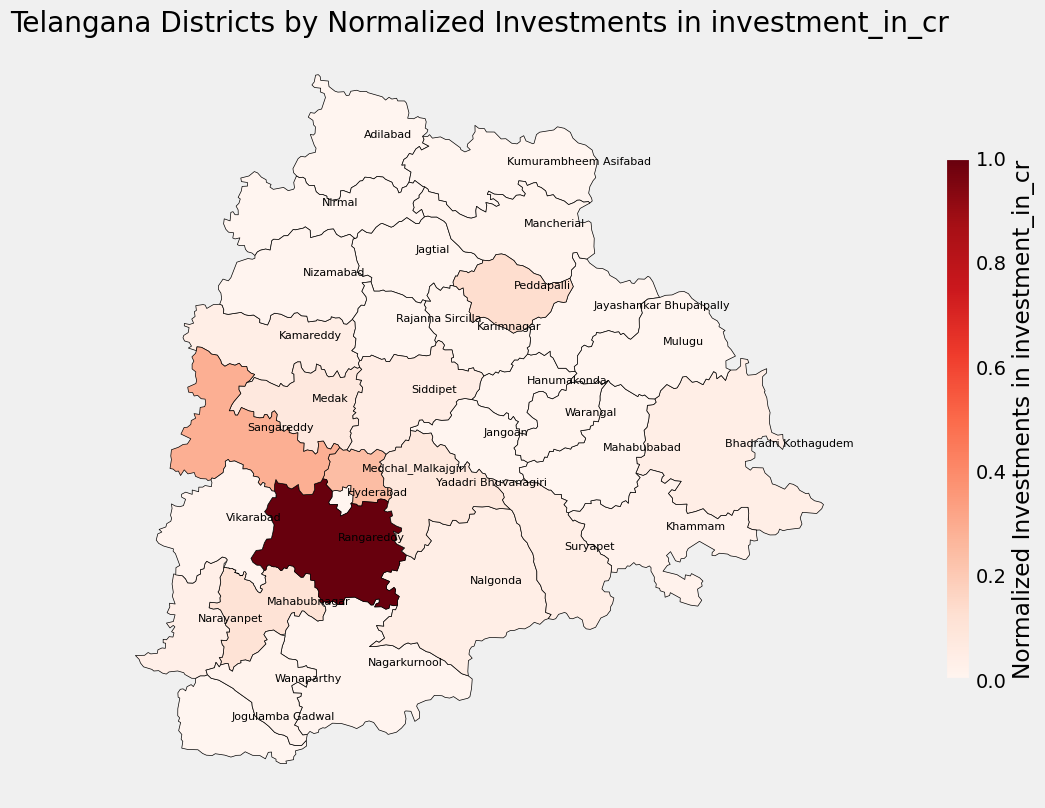

In [104]:
def visualize_district_investments(geo_data, district_investments, column_name, colormap):
    # Extract district and investment data
    data = district_investments[['district', column_name]]
    
    # Apply Min-Max scaling
    scaler = MinMaxScaler()
    data[column_name + '_normalized'] = scaler.fit_transform(data[[column_name]])
    
    # Create a dictionary for mapping
    normalized_investments_dict = dict(zip(data['district'], data[column_name + '_normalized']))
    
    # Normalize the values for color mapping
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Since we've normalized the data, the range is 0 to 1
    
    # Map the district names to their corresponding colors based on normalized investment values
    geo_data['color'] = geo_data['Dist_Name'].map(lambda x: colormap(norm(normalized_investments_dict.get(x, 0))))
    
    # Plot the map
    fig, ax = plt.subplots(figsize=(10, 10))
    geo_data.plot(ax=ax, edgecolor="k", facecolor=geo_data['color'])
    
    # Annotate district names
    for x, y, label in zip(geo_data.geometry.centroid.x, geo_data.geometry.centroid.y, geo_data['Dist_Name']):
        ax.annotate(label, xy=(x, y), xytext=(3,3), textcoords="offset points", fontsize=8)
    
    # Add a colorbar to the plot
    sm = plt.cm.ScalarMappable(cmap=colormap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', fraction=0.03, pad=0.1)
    cbar.set_label(f'Normalized Investments in {column_name}')
    
    ax.set_title(f"Telangana Districts by Normalized Investments in {column_name}")
    
    # Remove grid lines and axis ticks
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    
    # Save the plot as PNG
    save_path = os.path.join("D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8", f"{column_name}_investments_map.png")
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

# Merge the investment data with the geographical data
geo_data = geo_data.merge(sorted_districts_df, left_on="Dist_Name", right_on="district", how="left")

# Use the function
colormap = plt.cm.Reds  # You can choose any other colormap if you prefer
visualize_district_investments(geo_data, sorted_districts_df, 'investment_in_cr', colormap)

In [86]:
# Sorting the districts by investment in descending order and selecting the top 3
top_districts = district_investments.sort_values(by='investment_in_cr', ascending=False).head(3)
print(top_districts)

              district  investment_in_cr
25          Rangareddy          42706.35
26          Sangareddy          12366.87
16  Medchal_Malkajgiri          10394.57


In [88]:
# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment', 
           x=top_districts['district'], 
           y=top_districts['investment_in_cr'],
           marker=dict(color='blue'))  # Color of the bars
])

# Define the title string
plot_title = "Top 3 Districts with the Most Significant Investments from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='District',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

# Save the plot (modify the path as per your requirements)
plot_path = f"D:\\Telangana_Growth_Analysis\\notebooks\\plots\\ts_ipass\\8\\{plot_title}.html"
fig.write_html(plot_path)

fig.show()

In [101]:
# Filter the original investments DataFrame to only include the top 3 districts
filtered_data = investments[investments['district'].isin(top_districts['district'])]

# Group by district and fiscal_year, then sum the investments
grouped_data = filtered_data.groupby(['district', 'fiscal_year']).agg({
    'investment_in_cr': 'sum'
}).reset_index()

# Plotting
fig = go.Figure()

# Add a line for each district
for district in top_districts['district']:
    district_data = grouped_data[grouped_data['district'] == district]
    fig.add_trace(go.Scatter(x=district_data['fiscal_year'], 
                             y=district_data['investment_in_cr'], 
                             mode='lines+markers',
                             name=district))

# Define the title string
plot_title = "Yearly Investment Trend for Top 3 Districts from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='Fiscal Year',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    legend=dict(y=-0.2, x=0.4, xanchor='center', orientation='h')
)

fig.show()

In [90]:
# Grouping by sector and summing the investments
sector_investments = investments.groupby('sector').agg({
    'investment_in_cr': 'sum'
}).reset_index()

# Sorting the sectors by investment in descending order
sorted_sectors = sector_investments.sort_values(by='investment_in_cr', ascending=False)

# Identifying the sector with the highest investment
most_significant_sector = sorted_sectors.iloc[0]['sector']

In [91]:
most_significant_sector

'Real Estate,Industrial Parks and IT Buildings'

In [92]:
# Filtering the data for the identified "most significant sector"
filtered_data = investments[investments['sector'] == most_significant_sector]

# Grouping this filtered data by the 'district' column and summing the investments
district_investments_for_sector = filtered_data.groupby('district').agg({
    'investment_in_cr': 'sum'
}).reset_index()

In [93]:
# Sorting the districts by investment in descending order for the identified sector
sorted_districts_for_sector = district_investments_for_sector.sort_values(by='investment_in_cr', ascending=False)

# Selecting the top 3 districts
top_3_districts = sorted_districts_for_sector.head(3)

print(top_3_districts)

             district  investment_in_cr
2          Rangareddy          28970.28
1  Medchal_Malkajgiri            776.49
3          Sangareddy             20.96


In [96]:
# Colors for the bars
colors = ['lightblue', 'lightgreen', 'red']

# Plotting
fig = go.Figure(data=[
    go.Bar(name='Investment in Most Significant Sector', 
           x=top_3_districts['district'], 
           y=top_3_districts['investment_in_cr'],
           marker=dict(color=colors))  # Different color for each bar
])

# Define the title string
plot_title = f"Top 3 Districts with the Most Investments in {most_significant_sector} from FY 2019 to 2022"

# Update layout
fig.update_layout(
    title=plot_title,
    xaxis_title='District',
    yaxis_title='Investment in Cr',
    template="plotly_dark",
    legend=dict(y=-0.1, x=0.4, xanchor='center', orientation='h')
)

fig.show()

## The top 3 districts with the most significant investments during the fiscal years 2019 to 2022 are:

1. Rangareddy: ₹42,706.35 crores
2. Sangareddy: ₹12,366.87 crores
3. Medchal_Malkajgiri: ₹10,394.57 crores

### Factors That Might Have Led to Substantial Investments in These Districts:

- **Infrastructure & Connectivity:** Districts with well-developed infrastructure, including roads, railways, and airports, tend to attract more investments.

- **Proximity to Urban Centers:** Districts close to major cities or business hubs can attract more investments due to easy access to markets and skilled labor.

- **Government Policies:** Favorable government policies, incentives, and ease of doing business can play a significant role in attracting investments.

- **Availability of Resources:** The availability of natural resources, raw materials, or a skilled workforce can be a factor.

- **Existing Industries:** The presence of established industries can attract ancillary units or service providers leading to more investments.

The top 3 districts, Rangareddy, Sangareddy, and Medchal_Malkajgiri, are all situated around the capital city of Hyderabad, which is a major metropolis and a hub for several industries, especially IT, pharma, and biotech. This geographical proximity to Hyderabad plays a crucial role in their investment attraction. Here's a detailed analysis:

1. **Proximity to Hyderabad:**
   - **Business Ecosystem:** Hyderabad has a thriving business ecosystem, which naturally extends to its surrounding districts. Companies prefer to invest in nearby areas where they can still tap into the metropolitan ecosystem without facing the challenges of urban congestion.
   - **Ease of Expansion:** For companies already established in Hyderabad, it's easier to expand into nearby districts than to relocate to distant regions.

2. **Infrastructure & Connectivity:**
   - **Air Connectivity:** The presence of the Rajiv Gandhi International Airport in Hyderabad provides excellent air connectivity, facilitating international business and the movement of goods and services.
   - **Road and Rail:** These districts have well-connected road and rail networks, ensuring smooth transportation.

3. **Skilled Workforce:**
   - **Talent Pool:** Hyderabad boasts numerous premier institutions and universities. Companies in nearby districts can easily tap into this talent pool.
   - **Training and Development:** With several training centers and institutions in and around Hyderabad, companies have the advantage of continuous workforce upskilling.

4. **Real Estate & Development:**
   - **Space Availability:** While Hyderabad might have space constraints and higher real estate prices, surrounding districts offer ample space at competitive rates.
   - **Integrated Townships & SEZs:** Several integrated townships and Special Economic Zones (SEZs) in these districts cater to specific industries, providing state-of-the-art infrastructure and incentives.

5. **Government Initiatives:**
   - **Investment Policies:** The Telangana government has rolled out numerous investor-friendly policies, especially for these regions.
   - **Ease of Doing Business:** The state has made concerted efforts to simplify business regulations and processes, which benefits companies in these districts.

6. **Cluster Development:**
   - **Industry Clusters:** Over time, specific industry clusters have developed in these regions, such as IT in Rangareddy and Pharma in Sangareddy. Such clusters lead to a snowball effect, attracting more companies from the same sector due to shared resources, vendors, and knowledge.

7. **Quality of Life:**
   - **Urban Amenities with Peaceful Living:** These districts offer a balance between urban amenities and a peaceful living environment, making them attractive for employees and therefore employers.

In conclusion, the combination of proximity to Hyderabad, excellent infrastructure, a skilled workforce, and supportive government policies has made Rangareddy, Sangareddy, and Medchal_Malkajgiri top destinations for investments. It's a synergy of location, infrastructure, policy, and talent that converges to create an attractive investment proposition.


### Top 3 Districts with the Most Significant Sector Investment (FY 2019-2022)

#### Most Significant Sector Investment (FY 2019-2022) is Real Estate,Industrial Parks and IT Buildings

1. Rangareddy: ₹42,706.35 crores
2. Sangareddy: ₹12,366.87 crores
3. Medchal_Malkajgiri: ₹10,394.57 crores

## Report:

During the fiscal years 2019 to 2022, Rangareddy emerged as the district with the highest investments, amassing a staggering ₹42,706.35 crores. It is followed by Sangareddy with investments totaling ₹12,366.87 crores. The third spot is occupied by Medchal_Malkajgiri, having attracted ₹10,394.57 crores during the specified period.

These districts, all in close proximity to the metropolitan hub of Hyderabad, have showcased their potential as favorable investment destinations. Their strategic location, coupled with a conducive business environment, has made them the top choices for investors.

For entities looking to invest in the region, these districts clearly stand out as preferred choices, given their track record over the past years. Further, policymakers and local administrations can draw insights from these findings to devise strategies that bolster investment prospects for other districts as well.

## Anomaly:

The "Real Estate, Industrial Parks, and IT Buildings" sector alone attracted a massive ₹23,686.75 crores, which is the primary contributor to the anomaly.

### Contextual Factors:

The exceptionally high investment in the "Real Estate, Industrial Parks, and IT Buildings" sector suggests that there might have been significant infrastructure or real estate development projects in Rangareddy during 2019. This could be attributed to several factors:

- **Government Initiatives:** The Telangana government might have introduced favorable policies or incentives for infrastructure development, promoting real estate projects.

- **Demand for IT Spaces:** Given the booming IT industry in and around Hyderabad, there might have been an increased demand for IT parks and buildings, leading developers to invest heavily in the district.

- **Strategic Location:** Rangareddy's proximity to Hyderabad, the state's capital and a major IT hub, makes it an attractive destination for real estate and infrastructure developers.

- **Economic Climate:** The economic conditions in 2019 might have been conducive to large-scale investments in the district.

## Conclusion:

Rangareddy district saw a substantial investment in 2019, predominantly in the "Real Estate, Industrial Parks, and IT Buildings" sector. This anomaly suggests that there were significant infrastructure or real estate development projects during that year. Factors such as government initiatives, demand for IT infrastructure, the district's strategic location, and favorable economic conditions could have influenced this surge in investments. It would be beneficial to dive deeper into the specific projects and initiatives launched in 2019 in Rangareddy to gain a more comprehensive understanding.


## Note:
From 2019 to 2022, Hyderabad received a total investment of ₹55.8 crores. Given that Hyderabad is the capital city and a major commercial hub of Telangana, this figure appears surprisingly low. This discrepancy might be attributed to various factors, such as data limitations, investment shifts to neighboring districts, or specific policies and developments that directed larger projects outside the central city. A deeper exploration into the investment patterns, sectors, and city's strategic planning during these years would provide clarity on this unexpected trend.


